Di bagian 3, kita melihat bagaimana menggunakan jaringan klasifikasi untuk pengenalan digit MNIST. Biasanya kita mengasumsikan bahwa input adalah sebuah digit, sehingga kita dapat menormalkan output kelas jaringan sehingga mereka mewakili distribusi probabilitas yang jumlahnya menjadi satu. Namun seringkali dalam aplikasi kita ingin mengenali pola atau objek, tetapi tidak tahu apakah mereka ada dalam input. Sebagai contoh, kita bisa memiliki pengenal digit live, yang mengambil kamera sebagai input. Dalam kasus ini, kadang-kadang kita meletakkan kertas, misalnya sebuah surat dengan kode pos, di depan kamera, dan kadang-kadang tidak, yang seharusnya tidak membingungkan pengenal.

Dalam kasus seperti itu, masuk akal untuk menggunakan detektor, seperti yang kita lihat di bagian 1, untuk pengenalan. Ini memiliki keuntungan bahwa kita dapat melatih pengenal dari setiap kelas digit untuk mengeluarkan "1" (atau nilai yang mendekati) ketika ia mengenali digitnya, atau "0" (atau nilai yang mendekati) ketika ia tidak mengenali digitnya. Jika tidak ada digit yang hadir, semua detektor akan mengeluarkan nilai mendekati 0, yang merupakan sesuatu yang tidak dapat dilakukan oleh klasifikasi.

Untuk itu, kita menggunakan struktur jaringan saraf yang sama seperti di bagian 3 untuk klasifikasi MNIST, tetapi dengan fungsi Loss yang berbeda. Alih-alih CrossEntropyLoss(), kita menggunakan MSELoss(). Tetapi MSELoss membutuhkan representasi target yang berbeda.

Untuk CrossEntropyLoss, kita membutuhkan label kelas (angka) sebagai target, yang berarti kita memiliki satu digit input integer (atau float). MSELoss membutuhkan angka float untuk setiap kelas, yang berarti 10 angka float untuk setiap digit input, di mana kelas yang benar harus memiliki "1", dan semua kelas lain harus memiliki "0".

Karena data set MNIST dibuat untuk klasifikasi, kita perlu mengonversi targetnya ke kelas-kelas. Kita dapat melakukannya dengan menginisialisasi sebuah array torch dengan nol, dan kemudian mengaturnya menjadi "1" di kelas-kelas "benar" yang sesuai. Ini juga disebut representasi "one-hot".

In [ ]:
#from: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
#https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
#Translated to PyTorch and modified to a simple fully connected network,
#by Gerald Schuller, October 2019

# Ported and modified to Jupyter Notebook by Renato Profeta, August 2020

import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

In [ ]:
# define the neural network model
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.layer1=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_pixels))
        self.layer2=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_classes))


    def forward(self, x):
        x = F.relu(self.layer1(x))  #First layer with activation function
        x = self.layer2(x)   #Second layer
        #x = torch.nn.Softmax(x)
        return x

In [ ]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10  #10 classes according to the 10 possible digits 0,...,9

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/',
    train=True, download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)
#the Normalize() arguments are mean and standard deviation.

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/',
    train=False, download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 153802401.03it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74821305.64it/s]


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 104759249.84it/s]

Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16873807.59it/s]

Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw



In [ ]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one trainig batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print( "X_train.type()=",X_train.type(), "y_train.type()=",y_train.type())
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)

#Make classes with one-hot encoding from the target classes:
#y_train_onehot=torch.zeros(batch_size_train,num_classes)
#for spl in range(batch_size_train):
    #y_train_onehot[spl, y_train[spl]]=1.0
y_train_onehot=torch.nn.functional.one_hot(y_train).type(torch.FloatTensor)
print("y_train_onehot=", y_train_onehot)

X_train.type()= torch.FloatTensor y_train.type()= torch.LongTensor
batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([3, 1, 8, 2, 2, 5, 7, 6, 9, 5, 1, 0, 9, 4, 5, 9, 0, 3, 5, 9, 8, 4, 3, 5,
        4, 6, 2, 8, 2, 0, 4, 6, 9, 8, 0, 3, 8, 5, 4, 4, 2, 2, 7, 6, 7, 0, 3, 8,
        8, 8, 8, 1, 4, 5, 7, 5, 8, 6, 9, 0, 7, 4, 6, 2, 3, 1, 6, 7, 2, 7, 5, 5,
        3, 3, 7, 9, 6, 9, 3, 4, 4, 9, 5, 0, 1, 2, 8, 6, 1, 8, 9, 3, 3, 4, 7, 8,
        8, 4, 6, 0])
y_train_onehot= tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.

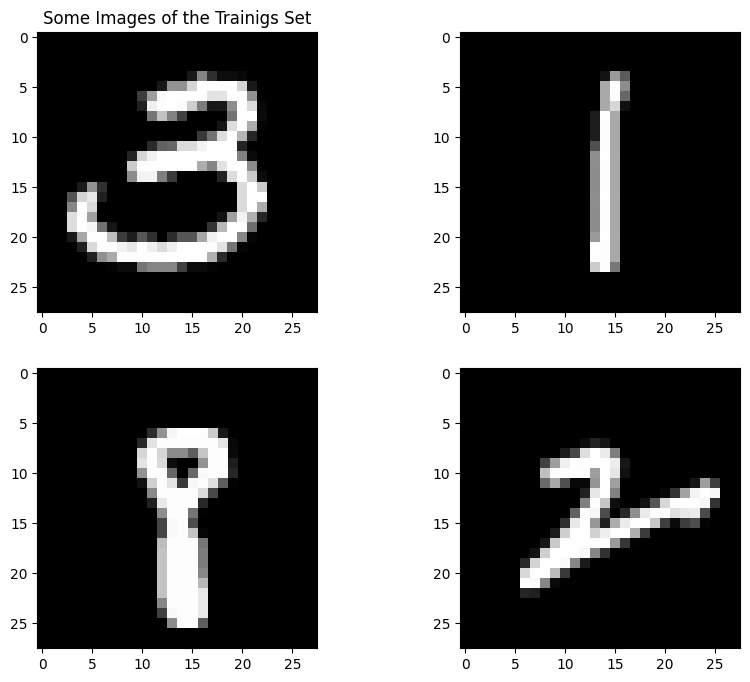

In [ ]:
examples = enumerate(test_loader)
#one test batch of batch_size_test images:
batch_idx, (X_test, y_test) = next(examples)
#Make classes with one-hot encoding from the target classes:
y_test_onehot=torch.zeros(batch_size_test,num_classes)
for spl in range(batch_size_test):
    y_test_onehot[spl, y_test[spl]]=1.0

# plot 4 images as gray scale
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]


#Flatten the images:
X_train = X_train.view(X_train.shape[0], num_pixels)
print("X_train.shape=",X_train.shape)
X_test = X_test.reshape(X_test.shape[0], num_pixels)
print("X_test.shape=",X_test.shape)

# normalize inputs from 0-255 to 0-1
#X_train = X_train / 255
#X_test = X_test / 255

# one hot encode outputs
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

X_train.shape= torch.Size([100, 784])
X_test.shape= torch.Size([10, 784])
